# 설정 파일 읽어오기

In [ ]:
import os, sys, time, requests

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [3]:
from common.config import get_config_info

In [59]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region, ExportPlatform
from msrest.authentication import ApiKeyCredentials

# 필수 기본 정보 설정

In [46]:
config = get_config_info(os.path.join('.', 'config', 'settings1.json'))

TRAINING_ENDPOINT = config['train_endpoint']
TRAINING_API_KEY = config['train_api_key']
PREDICTION_ENDPOINT = config['prediction_endpoint']
PREDICTION_API_KEY = config['prediction_api_key']
PREDICTION_RESOURCE_ID = config['prediction_resource_id']

# Trainer, Predictor 객체화

In [6]:
training_credentials = ApiKeyCredentials(in_headers={'Training-key': TRAINING_API_KEY})
prediction_credentials = ApiKeyCredentials(in_headers={'Prediction-key': PREDICTION_API_KEY})

trainer = CustomVisionTrainingClient(endpoint=TRAINING_ENDPOINT, credentials=training_credentials)
predictor = CustomVisionPredictionClient(endpoint=PREDICTION_ENDPOINT, credentials=prediction_credentials)

In [7]:
for project in trainer.get_projects():
    print('PROJECT : ', project.id, project.name)

for domain in trainer.get_domains():
    print('DOMAIN : ', domain.type, domain.name, domain.id)

DOMAIN :  Classification General [A2] 2e37d7fb-3a54-486a-b4d6-cfc369af0018
DOMAIN :  Classification General [A1] a8e3c40f-fb4a-466f-832a-5e457ae4a344
DOMAIN :  Classification General ee85a74c-405e-4adc-bb47-ffa8ca0c9f31
DOMAIN :  Classification Food c151d5b5-dd07-472a-acc8-15d29dea8518
DOMAIN :  Classification Landmarks ca455789-012d-4b50-9fec-5bb63841c793
DOMAIN :  Classification Retail b30a91ae-e3c1-4f73-a81e-c270bff27c39
DOMAIN :  Classification Adult 45badf75-3591-4f26-a705-45678d3e9f5f
DOMAIN :  Classification General (compact) [S1] a1db07ca-a19a-4830-bae8-e004a42dc863
DOMAIN :  Classification General (compact) 0732100f-1a38-4e49-a514-c9b44c697ab5
DOMAIN :  Classification Food (compact) 8882951b-82cd-4c32-970b-d5f8cb8bf6d7
DOMAIN :  Classification Landmarks (compact) b5cfd229-2ac7-4b2b-8d0a-2b0661344894
DOMAIN :  Classification Retail (compact) 6b4faeda-8396-481b-9f8b-177b9fa3097f
DOMAIN :  ObjectDetection General [A1] 9c616dff-2e7d-ea11-af59-1866da359ce6
DOMAIN :  ObjectDetection

# 프로젝트 만들기

In [8]:
project_name = '6b018-kitchen-compact'
project_description = '포크와 가위를 감지하는 모델'
domain_id = None
project_id = None

# 기존 프로젝트가 있는지 체크
for project in trainer.get_projects():
    if project.name == project_name:
        # 기존 프로젝트가 이미 존재하고 있기 때문에, 프로젝트 아이디를 들고온다.
        project_id = project.id
        break

# 모든 도메인 정보를 체크하고, 내가 원하는 도메인 정보와 일치할 경우, 도메인 아이디를 들고 온다.
for domain in trainer.get_domains():
    if domain.type == 'ObjectDetection' and domain.name == 'General (compact)':
        domain_id = domain.id
        break

if domain_id:
    # 프로젝트를 만들거나, 프로젝트를 들고 오면 된다.

    if project_id:
        # 이미 존재하는 경우, 프로젝트를 들고 온다.
        print('Project Exist')
        project = trainer.get_project(project_id=project_id)
    else:
        # 없는 경우에, 프로젝트를 생성한다.
        print('Project Create')
        project = trainer.create_project(project_name, project_description, domain_id)

print(project.id, project.name)

Project Create
2dfa0774-86ed-4872-96a9-2a708ccfcde1 6b018-kitchen-compact


# 태그 만들기

In [9]:
exist_tag_list = trainer.get_tags(project.id)
print(exist_tag_list)

fork_tag = None
scissors_tag = None

for tag in exist_tag_list:
    if tag.name == 'fork':
        print('fork tag 들고왔어')
        fork_tag = tag
    elif tag.name == 'scissors':
        print('scissors tag 들고왔어')
        scissors_tag = tag

if fork_tag is None:
    print('fork tag 만들었어')
    fork_tag = trainer.create_tag(project_id=project.id, name='fork')

if scissors_tag is None:
    print('scissors tag 만들었어')
    scissors_tag = trainer.create_tag(project_id=project.id, name='scissors')

print(fork_tag.id, fork_tag.name)
print(scissors_tag.id, scissors_tag.name)

[]
fork tag 만들었어
scissors tag 만들었어
5ca37392-6c33-463e-b4ab-12e565564ee3 fork
acbd5e43-df58-4d12-b56a-abb20bc2ba95 scissors


# Labeling 데이터 추가

In [10]:
# [x, y, width, height]
fork_image_regions = {
    "fork_1": [ 0.145833328, 0.3509314, 0.5894608, 0.238562092 ],
    "fork_2": [ 0.294117659, 0.216944471, 0.534313738, 0.5980392 ],
    "fork_3": [ 0.09191177, 0.0682516545, 0.757352948, 0.6143791 ],
    "fork_4": [ 0.254901975, 0.185898721, 0.5232843, 0.594771266 ],
    "fork_5": [ 0.2365196, 0.128709182, 0.5845588, 0.71405226 ],
    "fork_6": [ 0.115196079, 0.133611143, 0.676470637, 0.6993464 ],
    "fork_7": [ 0.164215669, 0.31008172, 0.767156839, 0.410130739 ],
    "fork_8": [ 0.118872553, 0.318251669, 0.817401946, 0.225490168 ],
    "fork_9": [ 0.18259804, 0.2136765, 0.6335784, 0.643790841 ],
    "fork_10": [ 0.05269608, 0.282303959, 0.8088235, 0.452614367 ],
    "fork_11": [ 0.05759804, 0.0894935, 0.9007353, 0.3251634 ],
    "fork_12": [ 0.3345588, 0.07315363, 0.375, 0.9150327 ],
    "fork_13": [ 0.269607842, 0.194068655, 0.4093137, 0.6732026 ],
    "fork_14": [ 0.143382356, 0.218578458, 0.7977941, 0.295751631 ],
    "fork_15": [ 0.19240196, 0.0633497, 0.5710784, 0.8398692 ],
    "fork_16": [ 0.140931368, 0.480016381, 0.6838235, 0.240196079 ],
    "fork_17": [ 0.305147052, 0.2512582, 0.4791667, 0.5408496 ],
    "fork_18": [ 0.234068632, 0.445702642, 0.6127451, 0.344771236 ],
    "fork_19": [ 0.219362751, 0.141781077, 0.5919118, 0.6683006 ],
    "fork_20": [ 0.180147052, 0.239820287, 0.6887255, 0.235294119 ]
}
 
scissors_image_regions = {
    "scissors_1": [ 0.4007353, 0.194068655, 0.259803921, 0.6617647 ],
    "scissors_2": [ 0.426470578, 0.185898721, 0.172794119, 0.5539216 ],
    "scissors_3": [ 0.289215684, 0.259428144, 0.403186262, 0.421568632 ],
    "scissors_4": [ 0.343137264, 0.105833367, 0.332107842, 0.8055556 ],
    "scissors_5": [ 0.3125, 0.09766343, 0.435049027, 0.71405226 ],
    "scissors_6": [ 0.379901975, 0.24308826, 0.32107842, 0.5718954 ],
    "scissors_7": [ 0.341911763, 0.20714055, 0.3137255, 0.6356209 ],
    "scissors_8": [ 0.231617644, 0.08459154, 0.504901946, 0.8480392 ],
    "scissors_9": [ 0.170343131, 0.332957536, 0.767156839, 0.403594762 ],
    "scissors_10": [ 0.204656869, 0.120539248, 0.5245098, 0.743464053 ],
    "scissors_11": [ 0.05514706, 0.159754932, 0.799019635, 0.730392158 ],
    "scissors_12": [ 0.265931368, 0.169558853, 0.5061275, 0.606209159 ],
    "scissors_13": [ 0.241421565, 0.184264734, 0.448529422, 0.6830065 ],
    "scissors_14": [ 0.05759804, 0.05027781, 0.75, 0.882352948 ],
    "scissors_15": [ 0.191176474, 0.169558853, 0.6936275, 0.6748366 ],
    "scissors_16": [ 0.1004902, 0.279036, 0.6911765, 0.477124184 ],
    "scissors_17": [ 0.2720588, 0.131977156, 0.4987745, 0.6911765 ],
    "scissors_18": [ 0.180147052, 0.112369314, 0.6262255, 0.6666667 ],
    "scissors_19": [ 0.333333343, 0.0274019931, 0.443627447, 0.852941155 ],
    "scissors_20": [ 0.158088237, 0.04047389, 0.6691176, 0.843137264 ]
}

# 이미지 업로드
- Labeling 을 위한 구역 설정
- 태그를 포함해서 이미지 파일 업로드

In [14]:
FORK_DIRECTORY = os.path.join('.', 'data', 'fork')
SCISSORS_DIRECTORY = os.path.join('.', 'data', 'scissors')

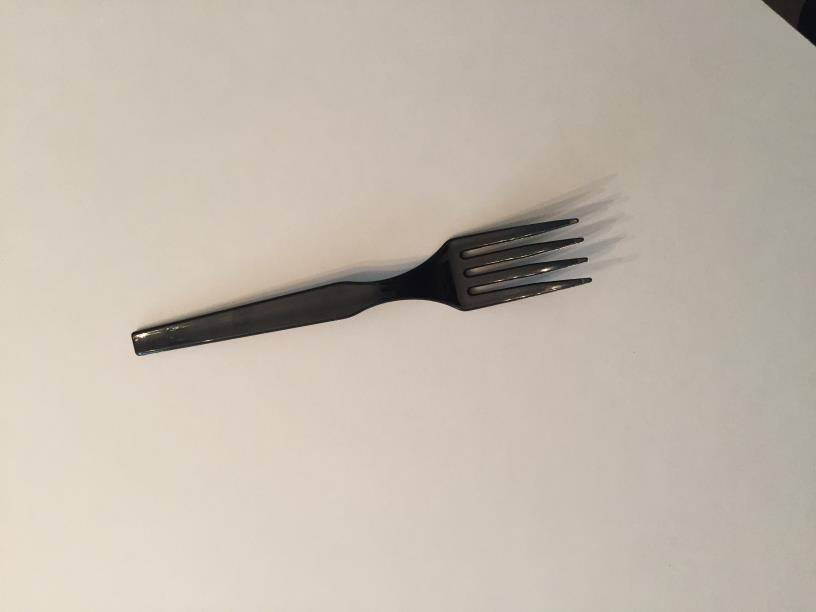

In [15]:
with open(os.path.join(FORK_DIRECTORY, 'fork_1.jpg'), 'rb') as image:
    image_data1 = image.read()

from IPython.display import display, Image
display(Image(data=image_data1))

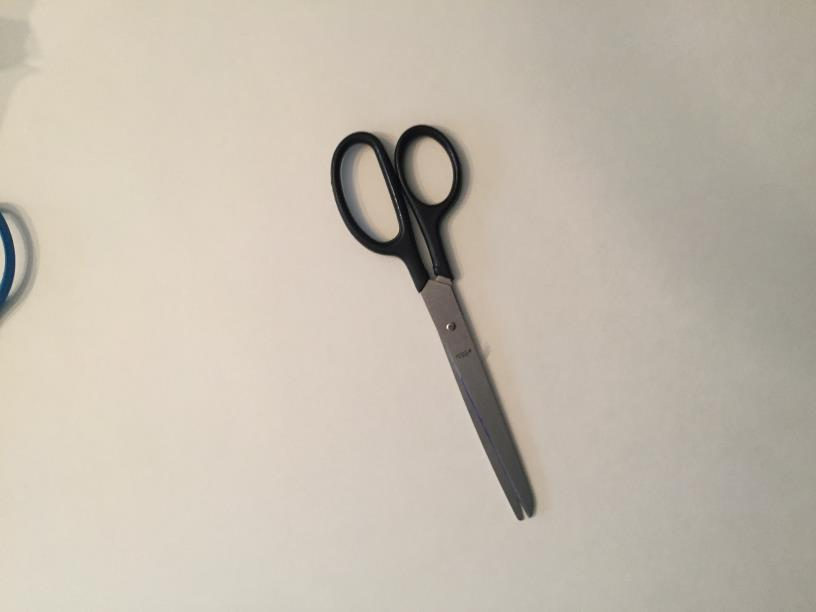

In [16]:
with open(os.path.join(SCISSORS_DIRECTORY, 'scissors_1.jpg'), 'rb') as image:
    image_data2 = image.read()

from IPython.display import display, Image
display(Image(data=image_data2))

In [ ]:
image_list = list()

for file_name in fork_image_regions.keys():
    with open(os.path.join(FORK_DIRECTORY, f'{file_name}.jpg'), 'rb') as image:
        # fork_image_region 정보를 들고와서 x, y, width, height 좌표를 들고와서
        # Region 정보를 만들어준다.
        left, top, width, height = fork_image_regions[file_name]
        region_list = [Region(tag_id=fork_tag.id, left=left, top=top, width=width, height=height)]

        # print(image)
        # image_data 를 ImageFileCreateEntry 를 만들어서 파일 리스트에 넣어준다.
        image_data = image.read()
        image_list.append(ImageFileCreateEntry(name=file_name, contents=image_data, regions=region_list))

for file_name in scissors_image_regions.keys():
    with open(os.path.join(SCISSORS_DIRECTORY, f'{file_name}.jpg'), 'rb') as image:
        # scissors_image_regions 정보를 들고와서 x, y, width, height 좌표를 들고와서
        # Region 정보를 만들어준다.
        left, top, width, height = scissors_image_regions[file_name]
        region_list = [Region(tag_id=scissors_tag.id, left=left, top=top, width=width, height=height)]

        # print(image)
        # image_data 를 ImageFileCreateEntry 를 만들어서 파일 리스트에 넣어준다.
        image_data = image.read()
        image_list.append(ImageFileCreateEntry(name=file_name, contents=image_data, regions=region_list))

In [27]:
def create_entry_list(image_list, directory, image_regions, tag_id):
    for file_name in image_regions.keys():
        with open(os.path.join(directory, f'{file_name}.jpg'), 'rb') as image:
            # image_regions 정보를 들고와서 x, y, width, height 좌표를 들고와서
            # Region 정보를 만들어준다.
            left, top, width, height = image_regions[file_name]
            region_list = [Region(tag_id=tag_id, left=left, top=top, width=width, height=height)]

            # print(image)
            # image_data 를 ImageFileCreateEntry 를 만들어서 파일 리스트에 넣어준다.
            image_data = image.read()
            image_list.append(ImageFileCreateEntry(name=file_name, contents=image_data, regions=region_list))

In [ ]:
image_list = list()
create_entry_list(image_list, FORK_DIRECTORY, fork_image_regions, fork_tag.id)
create_entry_list(image_list, SCISSORS_DIRECTORY, scissors_image_regions, scissors_tag.id)

In [29]:
print(len(image_list))
for c in image_list:
    print(c)

40
{'additional_properties': {}, 'name': 'fork_1', 'contents': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x02d\x030\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\x

In [30]:
print('IMAGE LIST LENGTH : ', len(image_list))
upload_result = trainer.create_images_from_files(project_id=project.id, batch=ImageFileCreateBatch(images=image_list))

IMAGE LIST LENGTH :  40


In [31]:
print(upload_result)

{'additional_properties': {}, 'is_batch_successful': True, 'images': [<azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B5010>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B51D0>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B52B0>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B5390>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B5470>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B5550>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B5630>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.Ima

In [33]:
print(upload_result)

if upload_result.is_batch_successful:
    print('Succeeded')
else:
    for image in upload_result.images:
        print('{} : {}'.format(image.source_url, image.status))

{'additional_properties': {}, 'is_batch_successful': True, 'images': [<azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B5010>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B51D0>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B52B0>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B5390>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B5470>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B5550>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageCreateResult object at 0x000002192E6B5630>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.Ima

In [34]:
trainer.get_iterations(project_id=project.id)

[]

In [ ]:
iteration1 = trainer.train_project(project_id=project.id)

In [36]:
iteration1

In [37]:
exist_iteration_list = trainer.get_iterations(project_id=project.id)
if len(exist_iteration_list) > 0:
    iteration2 = exist_iteration_list[0]
else:
    iteration2 = trainer.train_project(project_id=project.id)

print(iteration2.status)

Completed


In [39]:
while iteration2.status == 'Training':
    iteration2 = trainer.get_iteration(project_id=project.id, iteration_id=iteration1.id)
    print('Training Status : {}'.format(iteration2.status))
    time.sleep(5)

print('Completed!!!')
print(iteration2.status)

Completed!!!
Completed


# 배포

In [41]:
publish_name = '6b018-kitchen-v1'
response1 = trainer.publish_iteration(project_id=project.id, iteration_id=iteration2.id, publish_name=publish_name, prediction_id=PREDICTION_RESOURCE_ID)
response1

True

# 예측

In [ ]:
TEST_DIRECTORY = os.path.join('.', 'data', 'test')

with open(os.path.join(TEST_DIRECTORY, 'test_image.jpg'), 'rb') as image:
    image_data = image.read()

In [43]:
response2 = predictor.detect_image(project_id=project.id, published_name=publish_name, image_data=image_data)
print(response2)

{'additional_properties': {}, 'id': '26e2dbd8-db20-482b-9778-b6b8753d7f93', 'project': '2dfa0774-86ed-4872-96a9-2a708ccfcde1', 'iteration': '8c7c68a2-cf3a-4047-b47e-a663a85e2c2f', 'created': datetime.datetime(2025, 3, 26, 7, 23, 0, 513000, tzinfo=<isodate.tzinfo.Utc object at 0x000002192CF71550>), 'predictions': [<azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192EA23230>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192F0C7890>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192F0C7750>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192E47A520>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192E47A190>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x00

In [45]:
def print_prediction_result(response):
    for prediction in response.predictions:
        tag_name = prediction.tag_name
        probability = prediction.probability
        bounding_box = prediction.bounding_box

        if probability > 0.1:
            print('{} : {:0.2f}%'.format(tag_name, probability * 100))
            print(bounding_box)

In [44]:
print_prediction_result(response2)

fork : 94.09%
{'additional_properties': {}, 'left': 0.15922886, 'top': 0.20363757, 'width': 0.57273877, 'height': 0.6579788}


In [47]:
image_url_fork = config['test_url_fork']
image_url_scissors = config['test_url_scissors']

In [53]:
image_url_fork

'https://metamandate.com/wp-content/uploads/featured-fork-parts.jpg'

In [58]:
image_url_scissors

'https://m.media-amazon.com/images/I/61ANih8F+jL._AC_SX300_SY300_.jpg'

In [51]:
response3 = predictor.detect_image_url(project_id=project.id, published_name=publish_name, url=image_url_fork)
print(response3)

{'additional_properties': {}, 'id': '36291794-c453-4a86-ac26-21ef7c4ecebd', 'project': '2dfa0774-86ed-4872-96a9-2a708ccfcde1', 'iteration': '8c7c68a2-cf3a-4047-b47e-a663a85e2c2f', 'created': datetime.datetime(2025, 3, 26, 7, 32, 38, 364000, tzinfo=<isodate.tzinfo.Utc object at 0x000002192CF71550>), 'predictions': [<azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192F1B8E50>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192F1068F0>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192F0C1490>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192F0C19D0>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192F1C8100>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x0

In [52]:
print_prediction_result(response3)

scissors : 91.24%
{'additional_properties': {}, 'left': 0.14862084, 'top': 0.06006053, 'width': 0.4957024, 'height': 0.7486937}
fork : 90.93%
{'additional_properties': {}, 'left': 0.3053394, 'top': 0.37673688, 'width': 0.5642619, 'height': 0.55826974}
fork : 81.08%
{'additional_properties': {}, 'left': 0.19166905, 'top': 0.15016109, 'width': 0.5149465, 'height': 0.8498379}
scissors : 44.82%
{'additional_properties': {}, 'left': 0.37354356, 'top': 0.21337524, 'width': 0.5244483, 'height': 0.73272073}
scissors : 31.27%
{'additional_properties': {}, 'left': 0.2857989, 'top': 0.0, 'width': 0.5094669, 'height': 0.6603101}
fork : 27.70%
{'additional_properties': {}, 'left': 0.3941644, 'top': 0.0070652664, 'width': 0.48832217, 'height': 0.83646715}


In [54]:
response4 = predictor.detect_image_url(project_id=project.id, published_name=publish_name, url=image_url_scissors)
print(response4)

{'additional_properties': {}, 'id': 'fa78321e-c911-41e7-922e-ac5f94a6f48b', 'project': '2dfa0774-86ed-4872-96a9-2a708ccfcde1', 'iteration': '8c7c68a2-cf3a-4047-b47e-a663a85e2c2f', 'created': datetime.datetime(2025, 3, 26, 7, 33, 15, 717000, tzinfo=<isodate.tzinfo.Utc object at 0x000002192CF71550>), 'predictions': [<azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192EEE9FD0>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192EEE9AD0>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192F16BDD0>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192F16B150>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192F1681D0>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x0

In [55]:
print_prediction_result(response4)

scissors : 95.19%
{'additional_properties': {}, 'left': 0.45504794, 'top': 0.057309657, 'width': 0.540045, 'height': 0.8813311}
scissors : 52.97%
{'additional_properties': {}, 'left': 0.2758072, 'top': 0.0715819, 'width': 0.47564286, 'height': 0.8574095}
scissors : 42.32%
{'additional_properties': {}, 'left': 0.07898766, 'top': 0.33924922, 'width': 0.55158025, 'height': 0.6607498}


In [56]:
image_url_test = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Fork.agr.jpg/800px-Fork.agr.jpg'
response5 = predictor.detect_image_url(project_id=project.id, published_name=publish_name, url=image_url_test)
print(response5)

{'additional_properties': {}, 'id': '7710665c-b5a3-4601-b57b-9d1c947f3198', 'project': '2dfa0774-86ed-4872-96a9-2a708ccfcde1', 'iteration': '8c7c68a2-cf3a-4047-b47e-a663a85e2c2f', 'created': datetime.datetime(2025, 3, 26, 7, 38, 12, 228000, tzinfo=<isodate.tzinfo.Utc object at 0x000002192CF71550>), 'predictions': [<azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192EEE9850>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192EEEA0D0>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192EEE85D0>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192EEE8950>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x000002192EEEA050>, <azure.cognitiveservices.vision.customvision.prediction.models._models_py3.Prediction object at 0x0

In [57]:
print_prediction_result(response5)

fork : 89.21%
{'additional_properties': {}, 'left': 0.1065115, 'top': 0.12508056, 'width': 0.6325067, 'height': 0.66076756}
fork : 85.65%
{'additional_properties': {}, 'left': 0.32450584, 'top': 0.27648798, 'width': 0.6754931, 'height': 0.65619576}
fork : 12.99%
{'additional_properties': {}, 'left': 0.3531604, 'top': 0.0832437, 'width': 0.53899896, 'height': 0.6350213}
fork : 11.87%
{'additional_properties': {}, 'left': 0.014474243, 'top': 0.004679948, 'width': 0.52569854, 'height': 0.64559305}


# 모델 다운로드

In [60]:
export1 = trainer.export_iteration(project_id=project.id, iteration_id=iteration2.id, platform=ExportPlatform.onnx)
print(export1)

{'additional_properties': {}, 'platform': 'ONNX', 'status': 'Exporting', 'download_uri': None, 'flavor': None, 'newer_version_available': False}


In [64]:
exports = trainer.get_exports(project_id=project.id, iteration_id=iteration2.id)
export2 = exports[-1]
print(exports)
print(export2)

{'additional_properties': {}, 'platform': 'ONNX', 'status': 'Done', 'download_uri': 'https://[YOUR_DOWNLOAD_URI]', 'flavor': None, 'newer_version_available': False}


In [ ]:
# export 디렉토리가 없으면 새로 만든다.
DOWNLOAD_ZIP_FILE = os.path.join('.', 'data', 'export')

if not os.path.exists(DOWNLOAD_ZIP_FILE):
    os.makedirs(DOWNLOAD_ZIP_FILE)

In [67]:
response6 = requests.get(export2.download_uri)
with open(os.path.join(DOWNLOAD_ZIP_FILE, 'kitchen-v1.zip'), 'wb') as file:
    file.write(response6.content)